# Analitica de datos

## Proyecto 2020

### Daniel Galvis Torres y Sebastian Arango Vergara

Primero se importan las librerias

In [118]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
import seaborn as sns
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score #protocolo de evaluaciónw
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Se cargan los datos

In [119]:
df = pd.read_csv('PF-02-DatosTelco.csv',sep=',')
df.head()

,ESTADO,INGRESOS,CASA,PRECIO_DISPOSITIVO,MESES,DURACION,SOBRECARGO,SALDO_RESTANTE,SATISFACCION
0,VINCULADO,4074840,8.830000e+08,1444153.0,26,2.3,11.167542,20.3,1.762872
1,VINCULADO,8574088,1.745000e+09,2157661.0,23,3.7,0.000000,53.5,3.361266
2,RETIRADO,795993,9.500000e+07,452809.0,38,16.8,350.610224,13.9,8.359438
3,RETIRADO,8115015,8.300000e+07,2617184.0,37,17.6,230.913888,45.7,8.964017
4,RETIRADO,8187499,6.770000e+08,666069.0,19,0.0,131.541983,67.2,8.808206


## Parte 1

# 1. Limpieza de datos

## Identificacion de problemas

### Vistazo general

In [120]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ESTADO,23162,2,RETIRADO,11665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INGRESOS,23162,NaN,NaN,NaN,4.81312e+06,2.73737e+06,150000,2.1563e+06,6.13755e+06,7.34718e+06,9.65e+06
CASA,23162,NaN,NaN,NaN,7.16144e+08,4.81155e+08,8e+07,3.57e+08,6.24e+08,9.0775e+08,2.18e+09
PRECIO_DISPOSITIVO,23162,NaN,NaN,NaN,1.31534e+06,748570,200000,657184,1.23746e+06,1.82958e+06,4.7e+06
MESES,23162,NaN,NaN,NaN,24.1971,14.264,0,14,24,34,79
DURACION,23162,NaN,NaN,NaN,9.60985,7.04001,0,2.1,14.6,16.1,20.1
SOBRECARGO,23162,NaN,NaN,NaN,110.056,100.772,0,12.5669,75.3836,201.55,411.168
SALDO_RESTANTE,23162,NaN,NaN,NaN,42.9919,30.2045,0,15.2,37.65,70,130.7
SATISFACCION,23162,NaN,NaN,NaN,5.48084,2.80994,0.61358,2.7055,4.06455,8.26824,9.64262


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23162 entries, 0 to 23161
Data columns (total 9 columns):
ESTADO                23162 non-null object
INGRESOS              23162 non-null int64
CASA                  23162 non-null float64
PRECIO_DISPOSITIVO    23162 non-null float64
MESES                 23162 non-null int64
DURACION              23162 non-null float64
SOBRECARGO            23162 non-null float64
SALDO_RESTANTE        23162 non-null float64
SATISFACCION          23162 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.6+ MB


Podemos notar que no hay ningún valor nulo, por lo que no debemos preocuparnos de ese aspecto.
De igual forma, la variable categórica (Estado) tiene dos únicos valores, lo que también es normal.
Además, ningún valor númerico es menor a 0, por lo que desde este punto de vista no hay ninguna anomalía

### Se pasará a ver la distribución de los datos en las variables numéricas con boxplots:

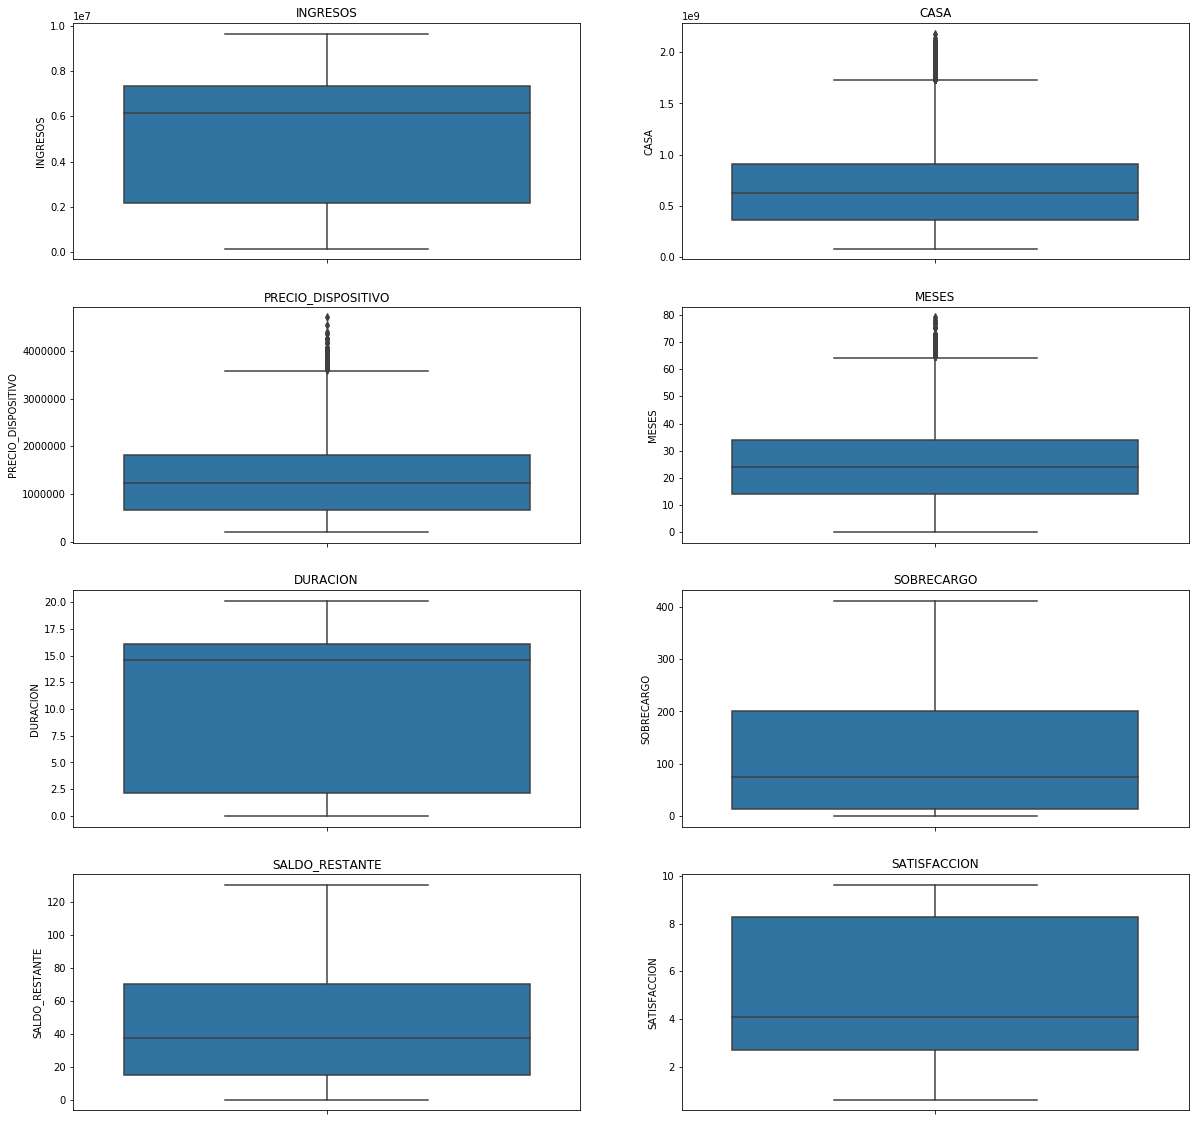

In [122]:
fig = plt.figure(figsize=(20,20))
i=1
for var_num in df.columns[1:]:
    ax = fig.add_subplot(4, 2, i) #Defino una tabla de 2 filas por 1 columnas, agrego el i-ésimo plot
    sns.boxplot(y=var_num, data=df)
    plt.title(var_num)
    i+=1

1. Existen outliers en CASA, PRECIO_DISPOSITIVO y en MESES.
Solo se eliminaran aquellos valores que esten a mas o menos de 4 std del promedio.

In [123]:
upper_bounds={}
lower_bounds={}
for var_num in df.columns[1:]:
    msk=df[var_num]
    upper_bounds[var_num]=msk.mean()+4*msk.std()
    lower_bounds[var_num]=msk.mean()-4*msk.std()
    
for var_num in df.columns[1:]:
    msk=df[var_num]
    print(var_num)
    print(upper_bounds[var_num])
    df=df[msk<=upper_bounds[var_num]]
    df=df[msk>=lower_bounds[var_num]]

INGRESOS
15762611.074484423
CASA
2640764007.11989
PRECIO_DISPOSITIVO
4309620.340600731
MESES
81.25319104113953
DURACION
37.76988146479488
SOBRECARGO
513.1423078633511
SALDO_RESTANTE
163.81004697843292
SATISFACCION
16.720589924444518


C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [124]:
df=df.reset_index(drop=True)

### Analisis correlación entre variables

In [125]:
preCorr = df.drop(columns="ESTADO")
preCorr.corr()

,INGRESOS,CASA,PRECIO_DISPOSITIVO,MESES,DURACION,SOBRECARGO,SALDO_RESTANTE,SATISFACCION
INGRESOS,1.000000,0.384465,-0.006736,-0.005715,-0.158182,-0.000666,0.844883,0.002619
CASA,0.384465,1.000000,0.001439,-0.002846,-0.063700,0.003249,0.326608,0.002450
PRECIO_DISPOSITIVO,-0.006736,0.001439,1.000000,-0.001461,0.011556,0.005013,-0.004230,-0.000413
MESES,-0.005715,-0.002846,-0.001461,1.000000,0.007094,0.004717,-0.003614,0.002726
DURACION,-0.158182,-0.063700,0.011556,0.007094,1.000000,0.001898,0.046901,0.000928
SOBRECARGO,-0.000666,0.003249,0.005013,0.004717,0.001898,1.000000,0.002447,0.889806
SALDO_RESTANTE,0.844883,0.326608,-0.004230,-0.003614,0.046901,0.002447,1.000000,0.004330
SATISFACCION,0.002619,0.002450,-0.000413,0.002726,0.000928,0.889806,0.004330,1.000000


Al analizar la correlación entre variables, podemos encontrar que 2 correlaciones son altas: la correlación entre SALDO_RESTANTE e INGRESOS (0.84) y la correlación entre SATISFACCION y SOBRECARGO (0.89).

Por esto, se puede utilizar PCA para mejorar el analisis posterior al hacer independiente las variables a costa de perder su interpretabilidad.

In [126]:
scaler = StandardScaler(with_mean=True, with_std=True)
pca = PCA()
df_estado=df[['ESTADO']]
df_var=df.drop(columns='ESTADO')
df_norm = pd.DataFrame(pca.fit_transform(scaler.fit_transform(df_var)))
df_pca = pd.concat([df_estado,df_norm],axis=1)

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\asus\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Se va a utilizar el protocolo de evaluación Holdout para calibrar y evaluar los modelos

In [145]:
data_x=df_pca.drop(columns='ESTADO')
data_y=df_pca[['ESTADO']]
X_train, X_test, y_train, y_test = train_test_split(data_x,data_y.values,
                                                    test_size=0.3,
                                                    random_state=12345,
                                                    stratify=data_y.values)

Antes de establecer las metricas a utilizar, se calcula el baseline:

In [128]:
print(df[df['ESTADO']=='RETIRADO'].size/df.size)

0.5036704378616461


Se define terminologia: positivo=RETIRADO, negativo=VINCULADO

Se decide utilizar las metricas de accuracy y recall. Accuracy debido a que las dos clases en los datos estan balanceadas, y recall porque es muy importante identificar aquellos clientes en riesgo de retirarse lo mas rapido posible, esto para despues fidelizarlos adecuadamente. 

### Calibración modelos: KNN

(0.9042890040299367, 0.9008571428571429, 29)


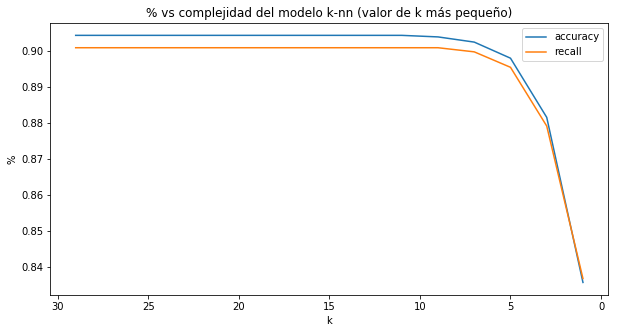

In [148]:
acc_test=[]
recall_test=[]
k_vec= np.arange(1,31,2)
bestK=(-1,-1,-1)
for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train.ravel())
    y_pred = knn.predict(X_test)
    acc_test.append(metrics.accuracy_score(y_test, y_pred))
    recall_test.append(metrics.recall_score(y_test, y_pred, pos_label='RETIRADO'))
    bestK=max(bestK,(acc_test[-1],recall_test[-1],k))
print(bestK)
plt.figure(figsize=(10,5))
ax = plt.gca() # get current axis
plt.plot(k_vec, acc_test)
plt.plot(k_vec, recall_test)
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('%')
plt.title('% vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['accuracy', 'recall'])

### Calibración modelos: arbol de decisión

## Parte 2

Primero, se crea otro DataFrame, que será una copia del DataFrame original pero solo con la información de los clientes retirados. Una vez realizada esta copia, se elimina la columna Estado

In [15]:
df_ret = df[df['ESTADO'] == 'RETIRADO']
df_ret = df_ret.drop('ESTADO', axis=1)
df_ret

,INGRESOS,CASA,PRECIO_DISPOSITIVO,MESES,DURACION,SOBRECARGO,SALDO_RESTANTE,SATISFACCION
2,795993,9.500000e+07,452809.0,38,16.8,350.610224,13.9,8.359438
3,8115015,8.300000e+07,2617184.0,37,17.6,230.913888,45.7,8.964017
4,8187499,6.770000e+08,666069.0,19,0.0,131.541983,67.2,8.808206
6,7256758,7.120000e+08,3493707.0,20,14.8,217.322554,69.5,8.285137
7,3262245,6.840000e+08,985708.0,32,1.3,275.595131,19.0,8.040629
9,874177,7.250000e+08,1403586.0,19,17.8,0.000000,19.9,2.138861
10,4061667,9.340000e+08,438256.0,9,1.8,0.000000,4.9,2.164890
11,3529836,7.240000e+08,647659.0,18,4.3,303.162095,29.6,7.984475
12,3829846,8.770000e+08,1150132.0,40,5.4,150.868408,33.2,7.855744
13,7639749,3.170000e+08,825889.0,27,0.7,178.247186,89.5,7.826984


Veamos cómo se ven los datos extraídos, sin normalizar ni separar en cluster, para hacernos una mejor idea sobre las decisiones a tomar. Para eso, primero se extraerán los componentes principales.

In [16]:
pca = PCA()
df_proyectado = pca.fit_transform(df_ret)

Veamos la varianza explicada por cada componente resultante:

In [17]:
var_exp=pca.explained_variance_ratio_ # varianza explicada por cada PC
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por los primeros n PCs
var_exp

array([9.99969953e-01, 2.76564087e-05, 2.39066729e-06, 2.59868168e-14,
       1.16411041e-15, 8.74808600e-16, 1.79879271e-16, 6.64807088e-18])

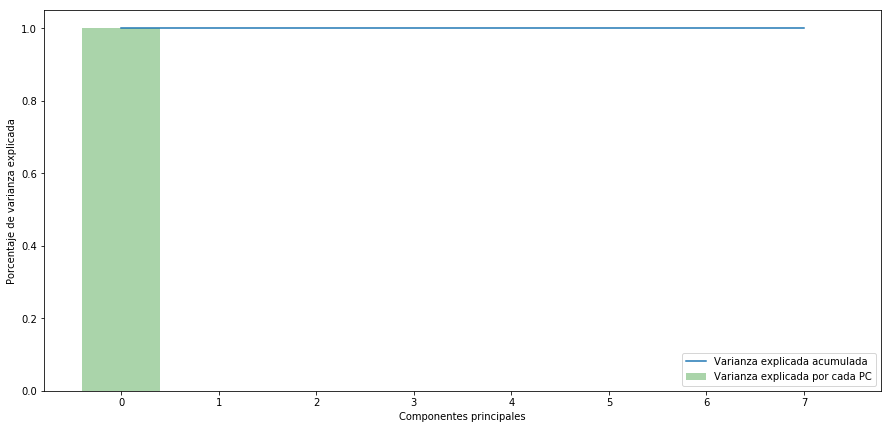

In [18]:
plt.figure(figsize=(15, 7))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Varianza explicada por cada PC', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.show()

El primer componente explica prácticamente el 100% de la varianza, lo que es un problema y definitivamente es necesario normalizar:

In [19]:
scaler = StandardScaler(with_mean=True, with_std=True)
df_ret_std = scaler.fit_transform(df_ret)

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\asus\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [20]:
pca = PCA()
df_ret_proyectado = pca.fit_transform(df_ret_std)

In [21]:
pca.explained_variance_ratio_

array([0.26062227, 0.21028733, 0.12918762, 0.12482655, 0.12300728,
       0.09615756, 0.03964466, 0.01626675])

In [22]:
var_exp=pca.explained_variance_ratio_ # varianza explicada por cada PC
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por los primeros n PCs
var_exp

array([0.26062227, 0.21028733, 0.12918762, 0.12482655, 0.12300728,
       0.09615756, 0.03964466, 0.01626675])

In [23]:
pca.components_[0:3]

array([[ 0.64830847,  0.41902514, -0.01646323, -0.01368638, -0.08647797,
         0.0364006 ,  0.62666998,  0.04622768],
       [ 0.04107945,  0.01210829, -0.02439065, -0.02805672, -0.01769301,
        -0.70591027,  0.03870106, -0.70474368],
       [-0.02934276,  0.00374945,  0.53858041,  0.22167522,  0.79601857,
        -0.01547408,  0.15941796, -0.02484137]])

El primer componente principal está determinado principalmente por la primera, segunda y septima columna, que corresponden a las variables "Ingresos", "Casa" y "Saldo restante".

El segundo componente principal está determinado principalmente por la sexta y octava columna, que corresponden a las variables "Sobrecargo" y "Satisfacción".

El primer componente principal está determinado principalmente por la tercera y quinta columna, que corresponden a las variables "Precio dispositivo" y "Duración".

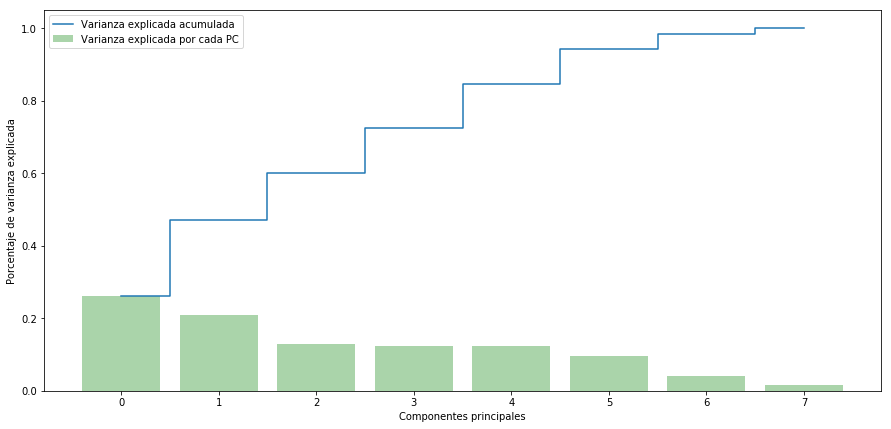

In [24]:
plt.figure(figsize=(15, 7))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Varianza explicada por cada PC', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.show()

Vemos que con los datos estandarizados los componentes son mucho más razonables. Entre los dos primeros componentes se explica casi el 50% de la varianza, mientras que si le agregamos el tercero se llega al 60%